In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os

from IPython.display import Image
from PIL import Image

import tensorflow as tf
from tensorflow import keras

# 데이터 불러오기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 데이터 경로, 불러오기

train_dir = "/content/drive/MyDrive/gender/train"
val_dir = "/content/drive/MyDrive/gender/val"
test_dir = "/content/drive/MyDrive/gender/test"

In [5]:
# 분류 클래스

classes = ['men', 'women']

num_classes = 2

In [6]:
# train, val, test 이미지 분리 및 저장

train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
)

val = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


# 데이터 확인

[2000, 2000]


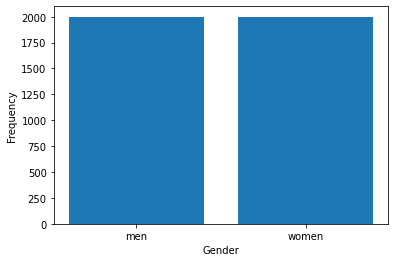

[500, 500]


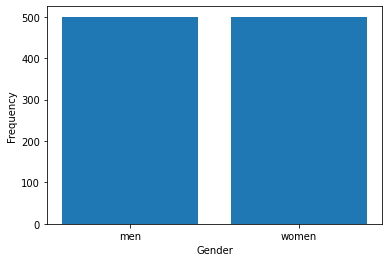

[300, 300]


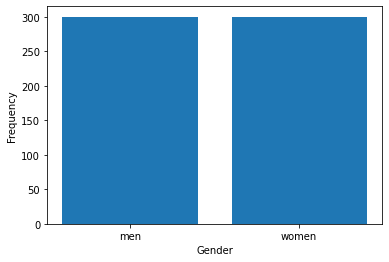

In [7]:
# 데이터 분포 확인

def gender_dist(path):
    frequencies = {}
    gender = []
    freq = []
    for i in os.listdir(path):
        gender.append(i)
        freq.append(len(os.listdir(path + '/' + i)))
    plt.bar(gender,freq, align='center')
    print(freq)
    plt.xlabel('Gender')
    plt.ylabel('Frequency')
    plt.show()
    
gender_dist(train_dir)
gender_dist(val_dir)
gender_dist(test_dir)

# 모델링

In [33]:
# 모델링 CNN

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='Same', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 dropout_26 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 64, 64, 64)      

In [34]:
# compile

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# early_stopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  verbose=1,
                                                  mode='min',
                                                  restore_best_weights=True
                                                 )

filepath = 'model_cnn.h5'

save_best = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      mode="auto",
                                                      save_freq="epoch",
                                                    )

In [36]:
# fit

history1 = model.fit(train, validation_data=val, epochs=10, verbose=1, callbacks=[early_stopping, save_best])

Epoch 1/10
125/125 [==============================] - 691s 5s/step - loss: 3.1293 - accuracy: 0.6100 - val_loss: 0.9616 - val_accuracy: 0.6310
Epoch 2/10
125/125 [==============================] - 689s 6s/step - loss: 0.9084 - accuracy: 0.6712 - val_loss: 0.8632 - val_accuracy: 0.7040
Epoch 3/10
125/125 [==============================] - 691s 6s/step - loss: 0.8471 - accuracy: 0.7055 - val_loss: 0.8573 - val_accuracy: 0.6660
Epoch 4/10
125/125 [==============================] - 681s 5s/step - loss: 0.8090 - accuracy: 0.7160 - val_loss: 0.8388 - val_accuracy: 0.6980
Epoch 5/10
125/125 [==============================] - 674s 5s/step - loss: 0.8044 - accuracy: 0.7283 - val_loss: 0.9027 - val_accuracy: 0.7040
Epoch 6/10
125/125 [==============================] - 674s 5s/step - loss: 0.7608 - accuracy: 0.7287 - val_loss: 0.7940 - val_accuracy: 0.7360
Epoch 7/10
125/125 [==============================] - 674s 5s/step - loss: 0.7386 - accuracy: 0.7508 - val_loss: 0.8218 - val_accuracy: 0.7020

# 모델링 ResNet50

In [48]:
# 모델링 ResNet50

from tensorflow.keras.applications import ResNet50

resnet = ResNet50(weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)
model_resnet = Model(resnet.input, predictions)
model_resnet.summary()

#model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [49]:
# compile

model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# early_stopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min',
                                                  restore_best_weights=True
                                                 )

filepath = 'model_ResNet50.h5'

save_best = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      mode="auto",
                                                      save_freq="epoch",
                                                    )

In [51]:
# fit

history2 = model_resnet.fit(train, validation_data=val, epochs=10, verbose = 1, callbacks=[early_stopping, save_best])

Epoch 1/10
125/125 [==============================] - 1023s 8s/step - loss: 0.3812 - accuracy: 0.8568 - val_loss: 0.3158 - val_accuracy: 0.8610
Epoch 2/10
125/125 [==============================] - 1020s 8s/step - loss: 0.2330 - accuracy: 0.9068 - val_loss: 0.3720 - val_accuracy: 0.8590
Epoch 3/10
125/125 [==============================] - 1013s 8s/step - loss: 0.2074 - accuracy: 0.9180 - val_loss: 0.4329 - val_accuracy: 0.8080
Epoch 4/10
125/125 [==============================] - 998s 8s/step - loss: 0.1809 - accuracy: 0.9355 - val_loss: 0.3178 - val_accuracy: 0.8590
Epoch 5/10
125/125 [==============================] - 997s 8s/step - loss: 0.1441 - accuracy: 0.9475 - val_loss: 0.3670 - val_accuracy: 0.8540
Epoch 6/10
125/125 [==============================] - 996s 8s/step - loss: 0.1161 - accuracy: 0.9565 - val_loss: 0.3815 - val_accuracy: 0.8680
Epoch 7/10
125/125 [==============================] - 998s 8s/step - loss: 0.1088 - accuracy: 0.9575 - val_loss: 0.4485 - val_accuracy: 0.8

# 모델 평가

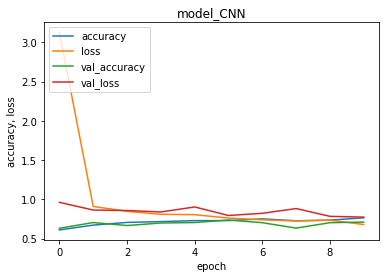

In [52]:
# model_CNN : epoch - accuracy, loss

plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.plot(history1.history['val_loss'], label='val_loss')

plt.title('model_CNN')
plt.xlabel('epoch')
plt.ylabel('accuracy, loss')
plt.legend(loc='upper left')
plt.show()

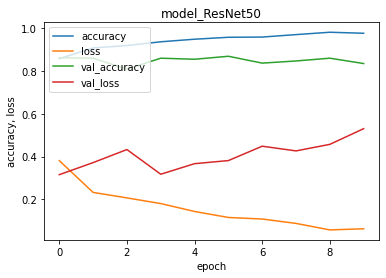

In [53]:
# model_ResNet50 : epoch - accuracy, loss

plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.plot(history2.history['val_loss'], label='val_loss')

plt.title('model_ResNet50')
plt.xlabel('epoch')
plt.ylabel('accuracy, loss')
plt.legend(loc='upper left')
plt.show()

In [54]:
# model_ResNet50
# test set : loss, accuracy

loss, acc = model_resnet.evaluate(test)
print(loss, acc)

19/19 [==============================] - 163s 7s/step - loss: 0.4033 - accuracy: 0.8800
0.40325143933296204 0.8799999952316284


# 사진으로 예측

In [57]:
def prediction(img):
  if predictions_test_1[0][0] > predictions_test_1[0][1]:
    print('남자입니다')
  else:
    print('여자입니다')

class_labels = ['men', 'women']

array([[0.7555765 , 0.34344512]], dtype=float32)

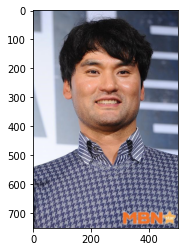

In [69]:
# 남자 사진으로 예측

import matplotlib.pyplot as plt

test_img_1 = plt.imread('/content/drive/MyDrive/park.jpg')

plt.imshow(test_img_1)

img_test_1 = keras.preprocessing.image.img_to_array(test_img_1)
img_test_1 = tf.expand_dims(img_test_1, 0)

predictions_test_1 = model_resnet.predict(img_test_1)
predictions_test_1

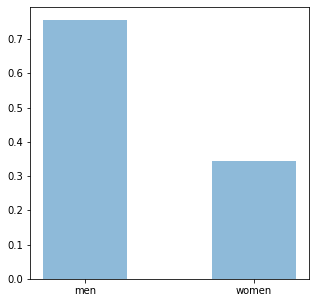

남자입니다


In [70]:
plt.figure(figsize=(5,5))
plt.bar(class_labels, predictions_test_1[0], width=0.5, alpha=0.5)
plt.show()

prediction(predictions_test_1)

array([[3.0335784e-04, 9.9910539e-01]], dtype=float32)

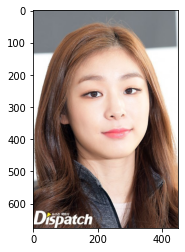

In [73]:
# 여자 사진으로 예측

import matplotlib.pyplot as plt

test_img_1 = plt.imread('/content/drive/MyDrive/kim.jpg')

plt.imshow(test_img_1)

img_test_1 = keras.preprocessing.image.img_to_array(test_img_1)
img_test_1 = tf.expand_dims(img_test_1, 0)

predictions_test_1 = model_resnet.predict(img_test_1)
predictions_test_1

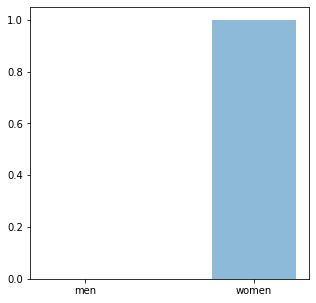

여자입니다


In [74]:
plt.figure(figsize=(5,5))
plt.bar(class_labels, predictions_test_1[0], width=0.5, alpha=0.5)
plt.show()

prediction(predictions_test_1)